# 4. Кластеризация по признаковому пространству

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", 50)

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook

import math

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import requests
import apimoex

### Импорт пользовательской библиотеки

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

# setting path
sys.path.append('..')

# importing
from my_lib import *

In [4]:
def ts_first_view(df):
    ticker = df['SECID'][0]
    print(f'####################################################################')
    print(f'_________________________{ticker}___________________________________')
    print(f'####################################################################')
    display(df.head(3))
    display(df.tail(3))
    plot_data(df['CLOSE'], title=f'График цены {ticker}')
    
    plot_timeStamps(df['CLOSE'])

## 4.1 Формирование признакового пространства

In [164]:
# Создаем заготовку
df_features = pd.DataFrame(index =df_price_history.drop(columns=['IMOEX']).columns)

# # Формируем признак "Полная относительно IMOEX доходность, %"
df_features['Полная относительно IMOEX доходность, %'] = df_percent_diff_last2base[-1:].T

Воспользуемся библиотекой tsfresh для генерации признаков из временных рядов

#### __Признаки относительной доходности г/г, %

Теперь перейдем к шкале год к году

In [165]:
# Переходим к приросту г/г, в %
df_percent_Y2Y = df_price_history.copy()
for col in df_percent_Y2Y.columns:
    df_percent_Y2Y[col] = 100*(df_percent_Y2Y[col] - df_percent_Y2Y[col].shift(1))/abs(df_percent_Y2Y[col].shift(1))

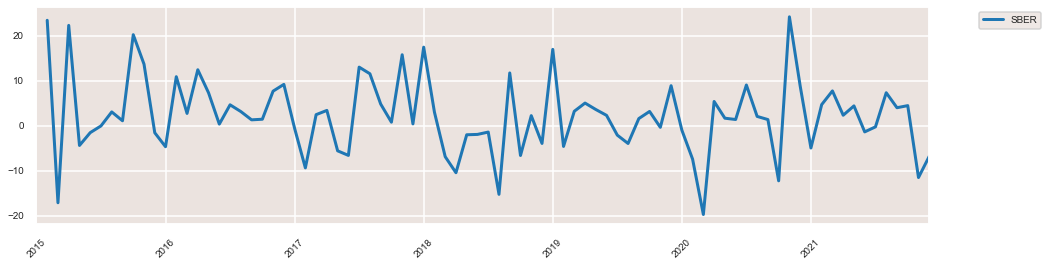

In [267]:
plot_data(df_percent_Y2Y['SBER'])

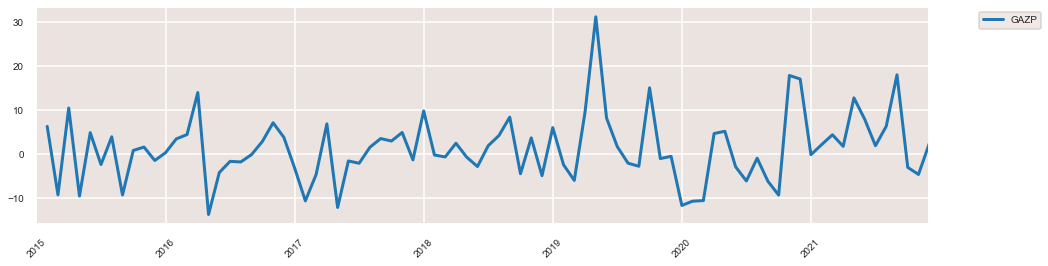

In [268]:
plot_data(df_percent_Y2Y['GAZP'])

In [169]:
# Переходим к отклонениям от IMOEX
df_percent_diff_Y2Y = df_percent_Y2Y.copy()
for col in df_percent_Y2Y.columns:
    df_percent_diff_Y2Y[col] = df_percent_diff_Y2Y[col] - df_percent_Y2Y['IMOEX']
    
df_percent_diff_Y2Y.drop(columns='IMOEX', inplace=True)

И построим графики динамики стандартного отклонения во времени

In [171]:
df_percent_diff_Y2Y = df_percent_diff_Y2Y[1:].rolling(6).aggregate(['std']).dropna()
df_percent_diff_Y2Y.columns = df_percent_Y2Y.drop(columns='IMOEX').columns

Посмотрим удастся ли визуально выделить динамику некоторых рядов

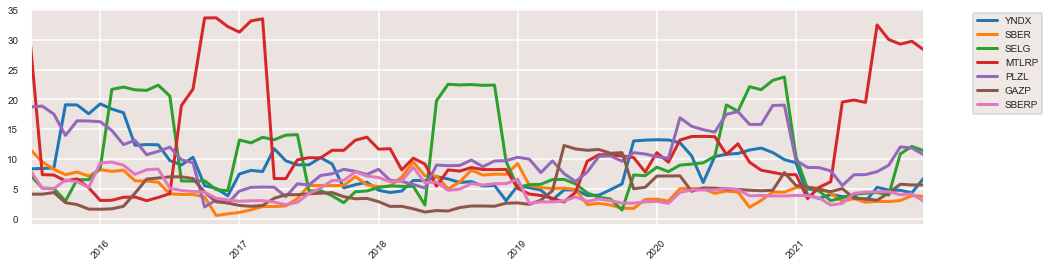

In [270]:
plot_data(df_percent_diff_Y2Y[['YNDX', 'SBER', 'SELG', 'MTLRP', 'PLZL', 'GAZP', 'SBERP']])

Отчетливо видим, что даже визуально можем выделить некоторые наблюдения, которым характерны сильные кратковременные колебания

Извлечем из этих рядов признаки:

In [173]:
tsfresh_features_Y2Y = get_tsfresh_features(df_percent_diff_Y2Y)
tsfresh_features_Y2Y.columns = [f'%г/г{i[1:]}' for i in list(tsfresh_features_Y2Y.columns)]

# Добавление к нашему пространству признаков
df_features = pd.concat([df_features, tsfresh_features_Y2Y], axis=1)
df_features.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.06it/s]


,"Полная относительно IMOEX доходность, %",%г/г__mean,%г/г__variance,%г/г__maximum
YNDX,195.207762,8.275735,17.801078,19.262815
AGRO,120.296551,7.333868,13.374149,20.378464
ALRS,-73.985713,5.643867,4.427819,10.951065
VTBR,-159.944087,6.526282,5.740069,13.843498
BSPB,82.407834,6.552822,7.400270,12.904485


## 4.2 EDA

### 4.2.1 Visual analysis

Сначала посмотрим на распределения признаков

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.42it/s]


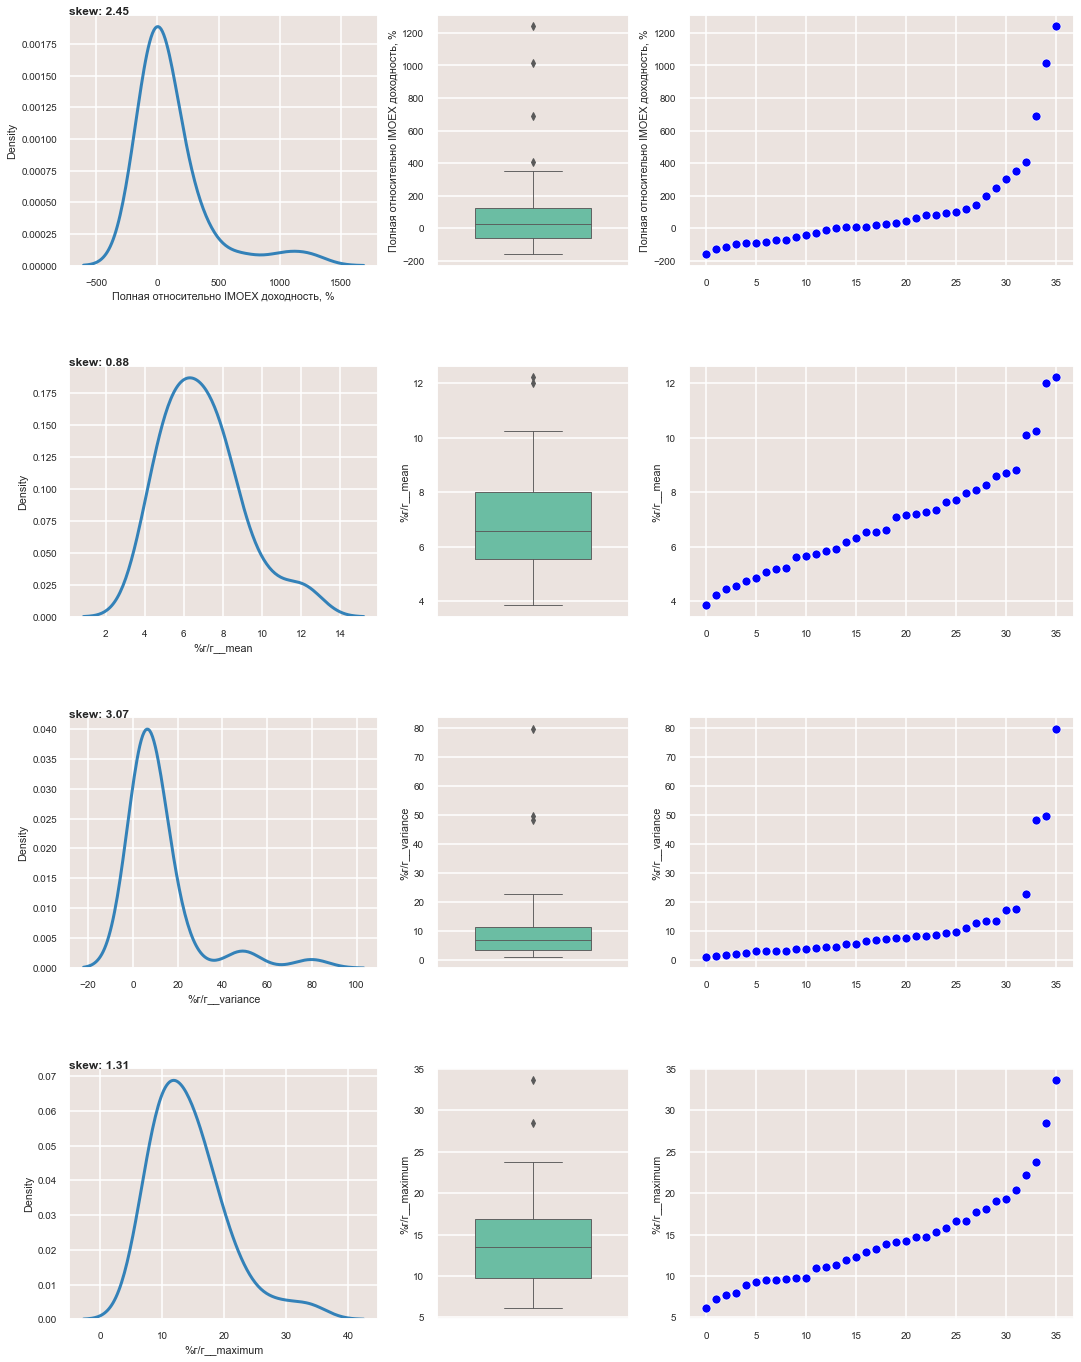

In [176]:
plot_numUFA(df_features, num_columns=list(df_features.columns))

Необходимо отметить наличие дллинных хвостов у некоторых признаков. Попробуем преобразовать признаки:

### 4.2.2 Descriptive Statitics

In [177]:
df_descibe = df_features.describe()

df_descibe.loc[['min', 'mean', '50%', 'max']]

,"Полная относительно IMOEX доходность, %",%г/г__mean,%г/г__variance,%г/г__maximum
min,-159.944087,3.851820,1.261599,6.129220
mean,116.714991,6.933697,11.715431,14.371176
50%,22.974140,6.584022,7.128640,13.547370
max,1242.341175,12.214816,79.840815,33.703163


Хорошо заметно сильное отличие среднего от медианы по некоторым признакам, что может намекать на наличие выбросов

Посмотрим на лин. коррекляцию между признаками

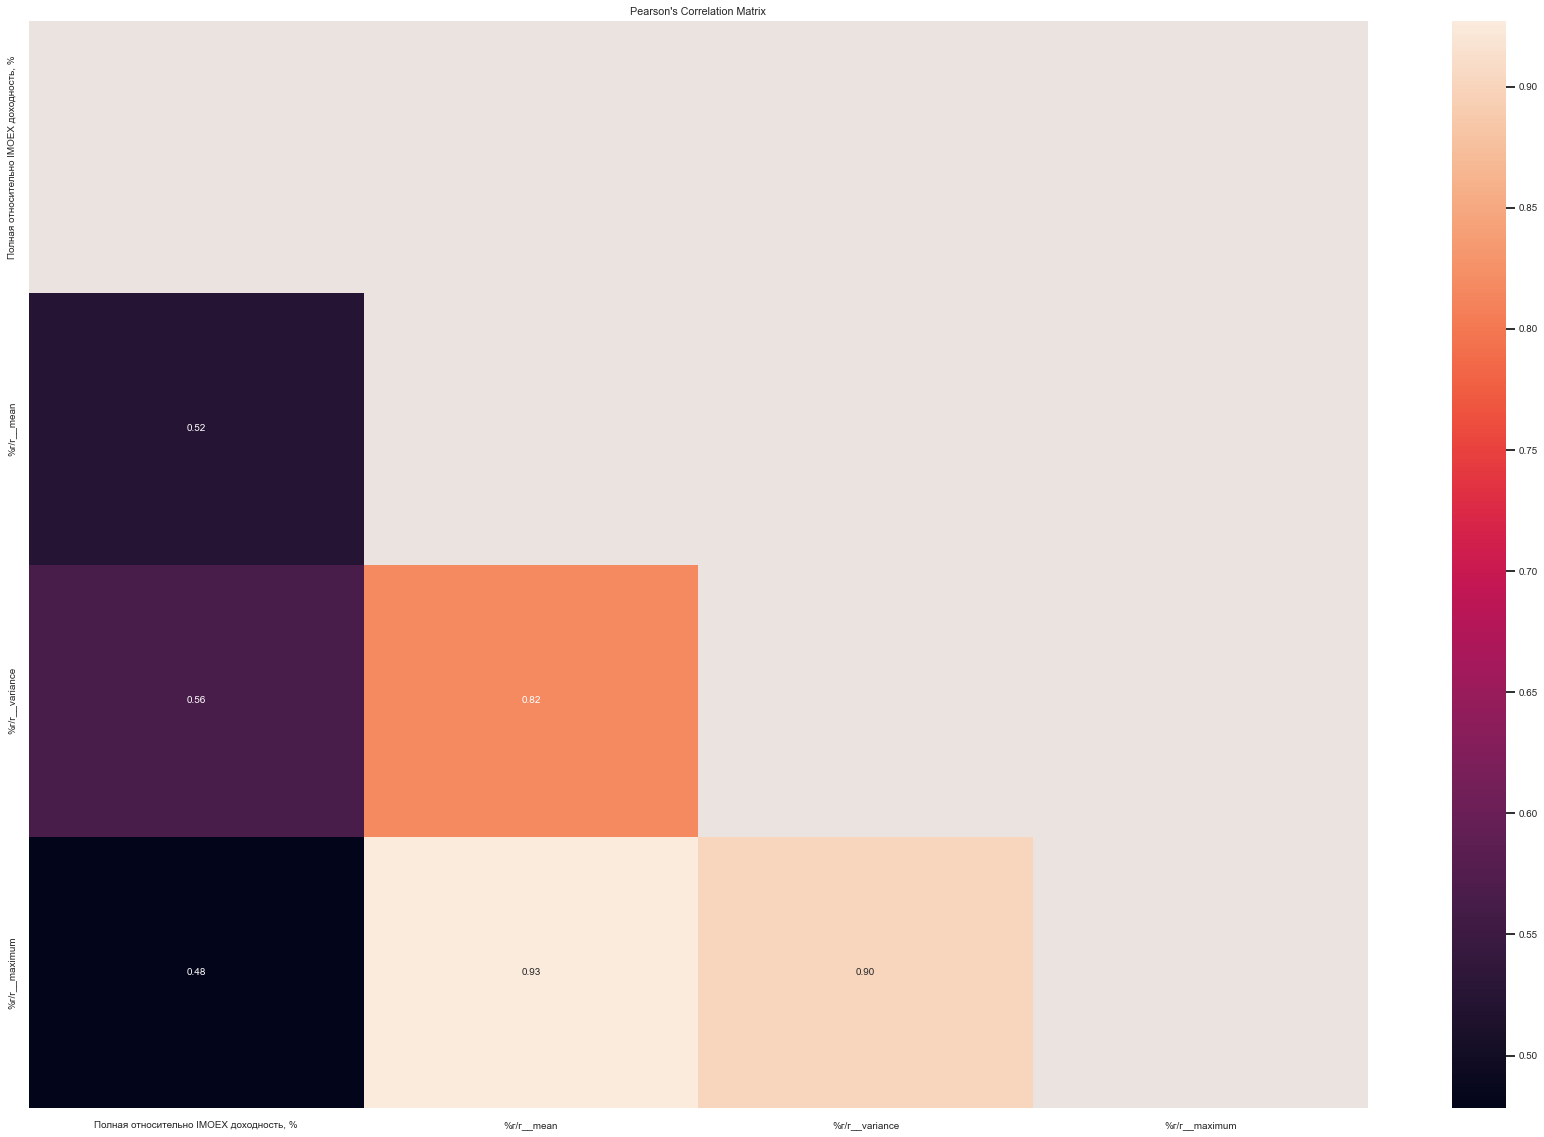

In [178]:
# Проверка ортогональности

corr = df_features.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(30, 20))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

Хорошо заметно наличие лин. корреляций между признаками. Для дальнейшего кластерного анализа необходимо привести данные к ортогональному виду

### 4.2.3 Преобразование данных

#### __Нормализация

Преобразование признака Полная относительно IMOEX доходность, %:
lambda = 0.8279313384356572:
Скос:    2.452 -> 0.444
Эксцесс: 6.353 -> 0.9


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s]


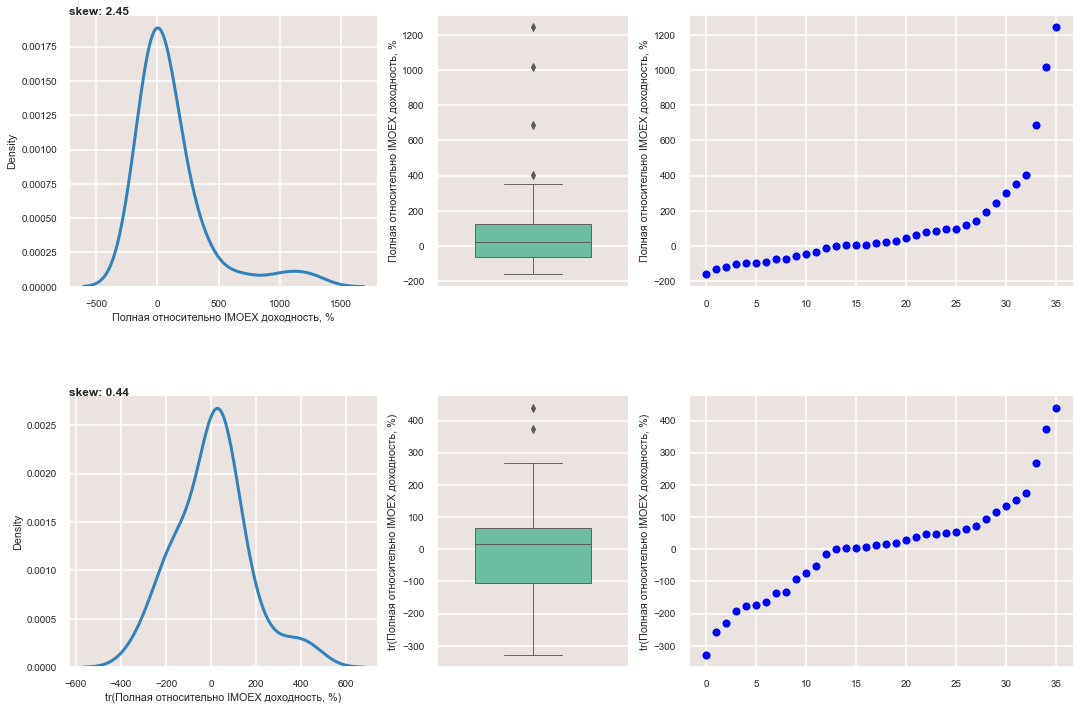

In [180]:
df_features_norm = df_features.copy()
columns = ['Полная относительно IMOEX доходность, %']
for col in columns:
    df_features_norm[col] = plot_bestNorm_transf(df_features, column_name=col)

Хорошо видно, что удалось значительно улучшить качество распределений признаков

#### __Ортонормировка (PCA)

Сначала стандартизируем наши данные

<AxesSubplot:title={'center':'После стандартизации'}>

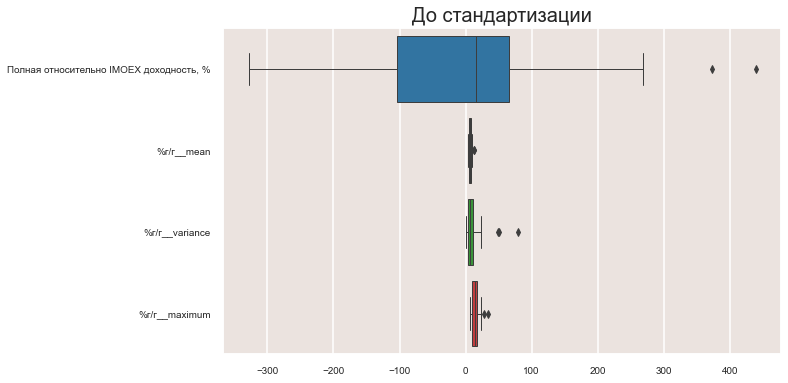

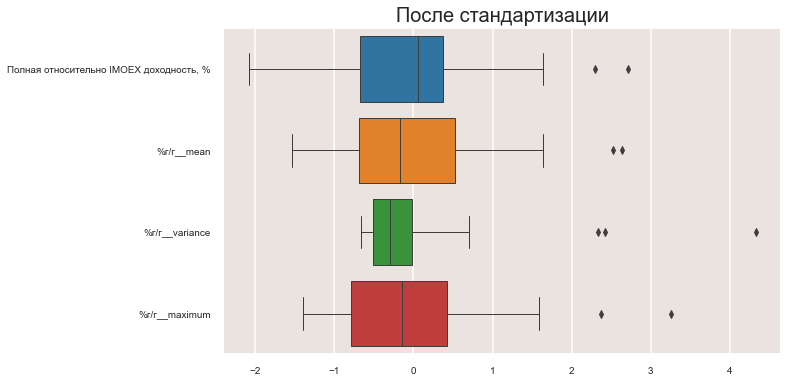

In [183]:
# Подготовка данных (стандартизация)
from sklearn.preprocessing import StandardScaler, MinMaxScaler


plt.figure(figsize=(10,6))
plt.title('До стандартизации', fontsize=20)
sns.boxplot(data=df_features_norm, orient='h')

scaler = StandardScaler()
scaler.fit(df_features_norm)
df_features_norm_scaled = pd.DataFrame(scaler.transform(df_features_norm), columns = scaler.get_feature_names_out())

plt.figure(figsize=(10,6))
plt.title('После стандартизации', fontsize=20)
sns.boxplot(data=df_features_norm_scaled, orient='h')

Теперь посмотрим на вклад главных компонент при разложении PCA

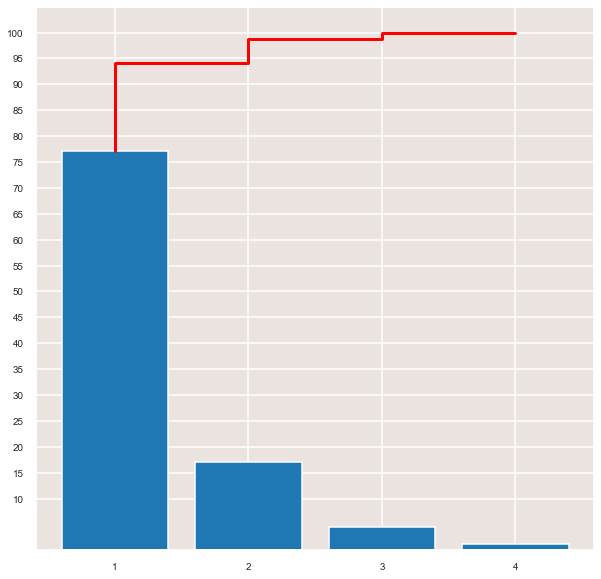

In [184]:
plot_PCA_Explorer(df_features_norm_scaled)

Очевидно, что первые шесть главных компонент объясняют более 95% дисперсии в данных

In [185]:
# Преобразование
df_features_norm_scaled_PCA = PCA_transformation(df_features_norm_scaled, n_components=3)

Проверим на ортогональность

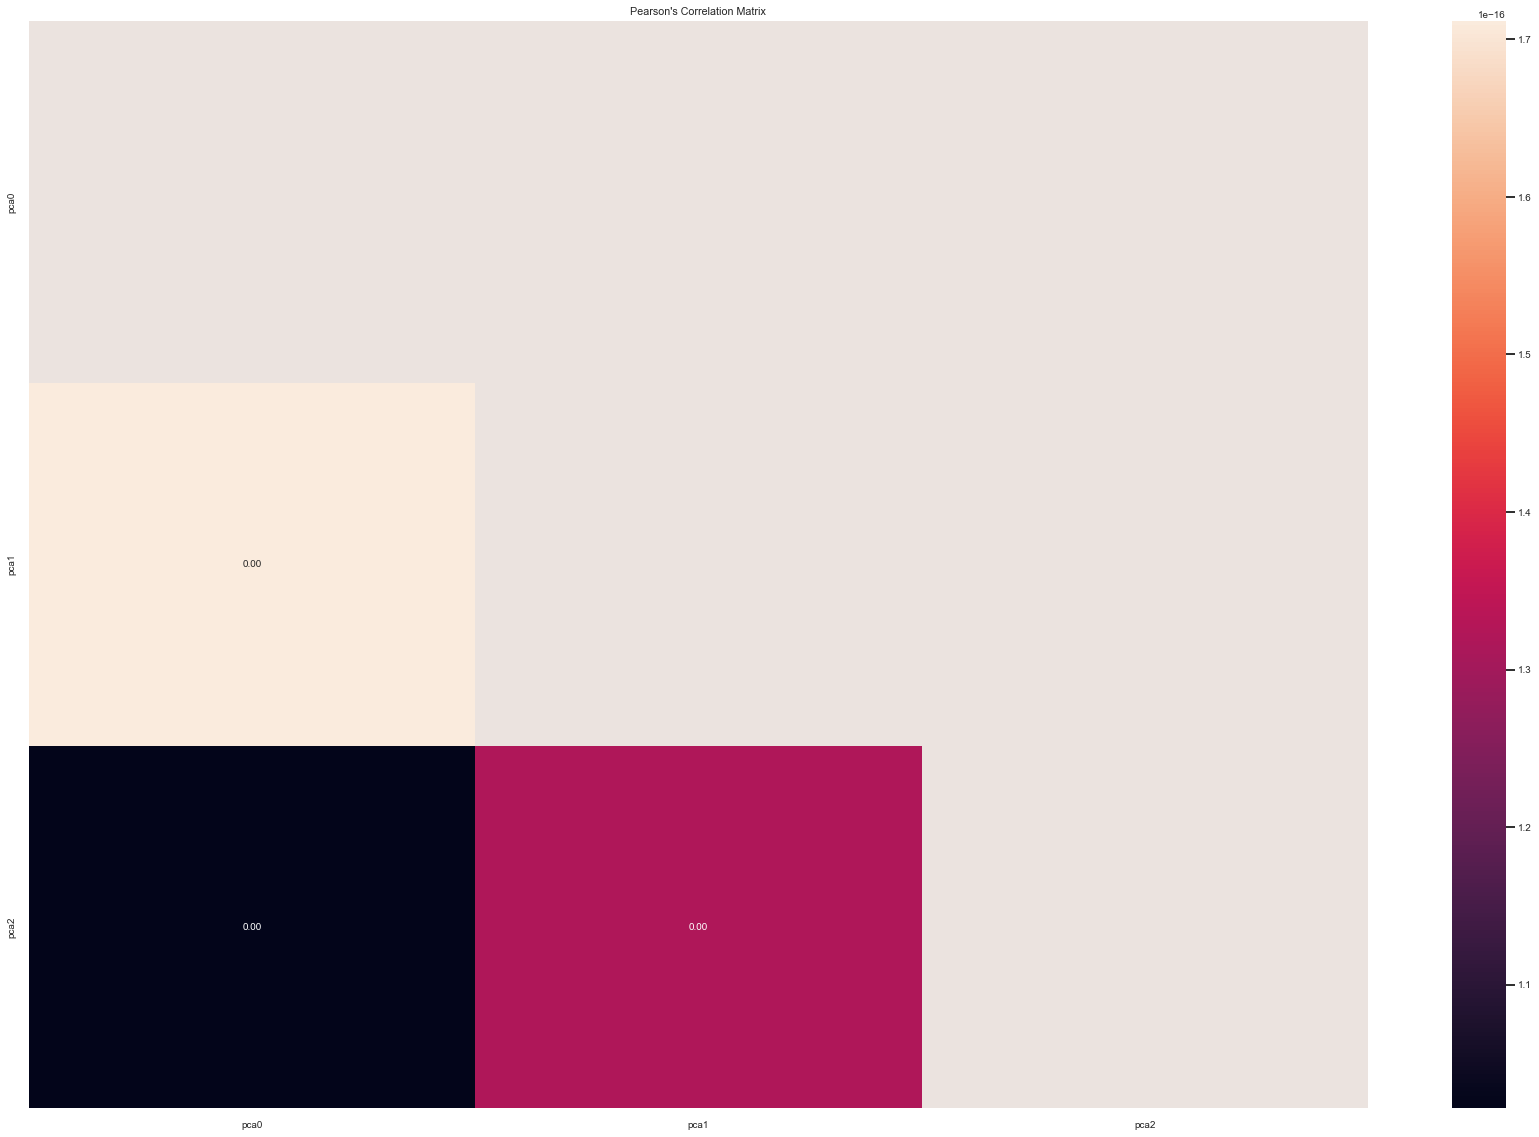

In [186]:
# Проверка ортонормировки

corr = df_features_norm_scaled_PCA.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(30, 20))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

Отлично, все признаки ортогональны

Еще раз стандартизируем получившиеся признаки

<AxesSubplot:title={'center':'После стандартизации'}>

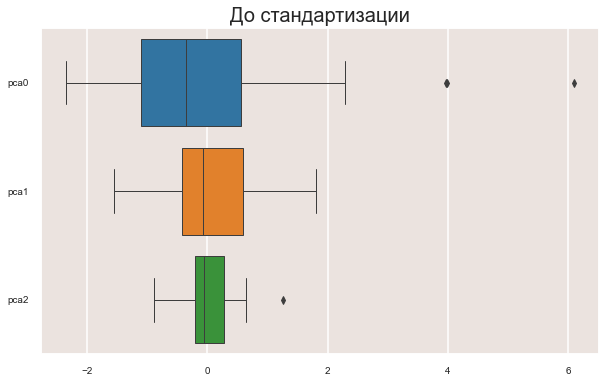

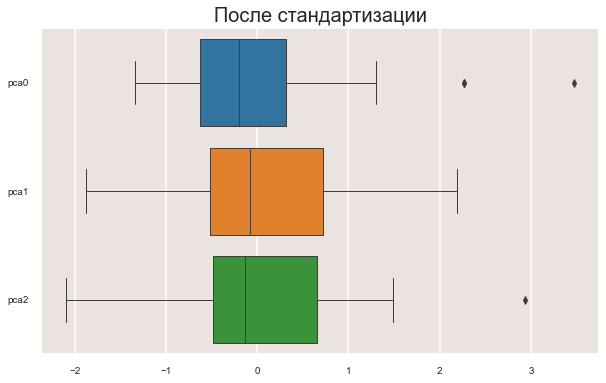

In [187]:
plt.figure(figsize=(10,6))
plt.title('До стандартизации', fontsize=20)
sns.boxplot(data=df_features_norm_scaled_PCA, orient='h')

scaler = StandardScaler()
scaler.fit(df_features_norm_scaled_PCA)
df_features_norm_scaled_PCA = pd.DataFrame(scaler.transform(df_features_norm_scaled_PCA), columns = scaler.get_feature_names_out())

plt.figure(figsize=(10,6))
plt.title('После стандартизации', fontsize=20)
sns.boxplot(data=df_features_norm_scaled_PCA, orient='h')

## 4.3 Outliers research

Посмотрим получится ли выделить наблюдения, характеризующиеся нетипичным поведением.
Исследовать на наличие выбросов будем проводить следующими методами:
- IQR;
- Distance_based;
- DBSCAN;
- isolation forest

После выделяются максимально встречающиеся выьросы

#### __IQR

In [190]:
X_to_clean = df_features_norm_scaled_PCA.copy()

IQR_dict, bounds_table = get_IQR(X_to_clean, threshold=1.5)
IQR_outl_col_1, IQR_outl_col_weighed_1, union_IQR = get_agg_IQR(X_to_clean, IQR_dict, threshold=1.5)
#IQR_outl_col_weighed_1.sort_values(by='IQR_weighed', ascending=False).head()
IQR_outl_col_1.value_counts()

IQR_outl
0           35
1            1
dtype: int64

#### __Distance_base

In [192]:
X_train   = df_features_norm_scaled_PCA
X_predict = df_features_norm_scaled_PCA

# Определение предиктора
predictor= DistanceOutliers_v2(outl_percent=10)

# Обучение
predictor.fit(X_train)

# Предсказание
distance_outliers_col,  distance_outliers_col_weighed  = predictor.predict(X_predict)

# Отчет
outl_cnt = pd.DataFrame(distance_outliers_col.value_counts(), columns=['count'])
percent = pd.DataFrame(distance_outliers_col.value_counts(normalize=True), columns=['%'])*100

display(pd.concat([outl_cnt, percent], axis=1))

,count,%
Distance_outl,,
0,33,91.666667
1,3,8.333333


Метод Distance_base выдели три наблюдения в качестве выбросов

#### __DBSCAN

Сначала исследуем темпы изменения среднего расстояния между наблюдениями при разных параметрах плотности

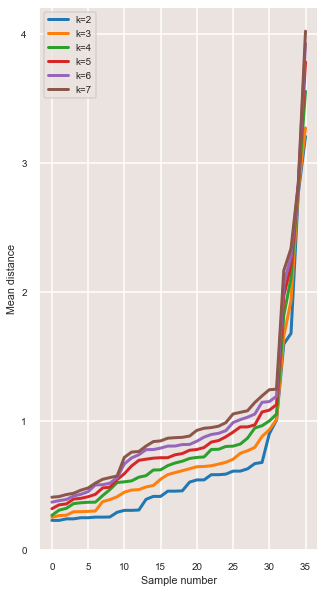

In [195]:
DBscan_explorer(df=df_features_norm_scaled_PCA, k_samples=[2, 3, 4, 5, 6, 7])

По началу сильного перегиба можем выделить потенциальную область параметров для исследования:
- eps: от 0.5 до 1.5.

In [196]:
EPS_RANGE=np.arange(0.5,1.5,0.1).round(2)
SAMPLES_RANGE=[2, 3, 4, 5, 6, 7]

DBSCAN_results = DBSCAN_explorer_v2(df_features_norm_scaled_PCA, EPS_RANGE=EPS_RANGE, SAMPLES_RANGE=SAMPLES_RANGE, METRICS='euclidean')

Теперь посмотрим на данные, которые нам удалось извлечь:

In [197]:
DBSCAN_results[DBSCAN_results['noise']>0.1].sort_values(by='silhouette', ascending=False).head(15)

,silhouette,clusters,noise
"eps=1.4, samples=7",0.505077,1.0,11.0
"eps=1.3, samples=2",0.505077,1.0,11.0
"eps=1.1, samples=2",0.505077,1.0,11.0
"eps=1.1, samples=3",0.505077,1.0,11.0
"eps=1.1, samples=4",0.505077,1.0,11.0
"eps=1.1, samples=5",0.505077,1.0,11.0
"eps=1.2, samples=2",0.505077,1.0,11.0
"eps=1.2, samples=3",0.505077,1.0,11.0
"eps=1.2, samples=4",0.505077,1.0,11.0
"eps=1.2, samples=5",0.505077,1.0,11.0


In [198]:
clusters_col, DSCAN_outliers_col = get_DBSCAN_clusters_outliers(df_features_norm_scaled_PCA, EPS=1.4, MIN_SAMPLES=7)
display(clusters_col.value_counts())
display(DSCAN_outliers_col.value_counts())

DBSCAN_clusters
0                  36
dtype: int64

DSCAN_outliers
0                 32
1                  4
dtype: int64

Метод DBSCAN выделил два наблюдения в качестве выбросов

#### __iforest

In [199]:
from sklearn.ensemble import IsolationForest

def iforest_scorer(df: pd.DataFrame, n_mean: int=1) -> pd.DataFrame:
    
    iforest_scores = pd.DataFrame()
    
    for i in range(0,n_mean):
        iforest = IsolationForest(n_estimators=100, random_state=i).fit(df)
        iforest_scores = pd.concat([iforest_scores, 
                                    pd.DataFrame(iforest.score_samples(df), columns=[f'iforest_weights_{i}'])], axis=1)
        
    
    
    iforest_scores['iforest_weights'] = iforest_scores.mean(axis=1)
    iforest_scores[['iforest_weights']] = iforest_scores[['iforest_weights']]/iforest_scores[['iforest_weights']].min()
    return iforest_scores[['iforest_weights']]

In [200]:
iforest_outl_col_weighed = iforest_scorer(df=df_features_norm_scaled_PCA, n_mean=3)

array([[<AxesSubplot:title={'center':'iforest_weights'}>]], dtype=object)

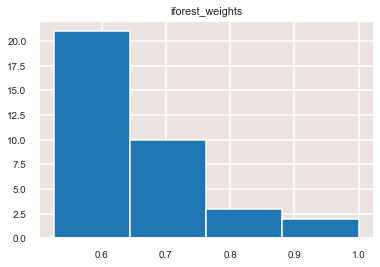

In [203]:
iforest_outl_col_weighed.hist(bins=4)

In [206]:
iforest_outl_col = iforest_outl_col_weighed['iforest_weights'].apply(lambda x: 0 if x <= 0.8 else 1)
display(iforest_outl_col.value_counts())

0    32
1     4
Name: iforest_weights, dtype: int64

Метод isolation forest выделил четыре наблюдения в качестве выбросов

#### _обобщение результатов

Обобщим результаты всех методов

In [207]:
summary = pd.concat([
                     distance_outliers_col,  
                     DSCAN_outliers_col, 
                     iforest_outl_col], axis=1)
summary_outlier_score = summary.mean(axis=1)
simple_score = summary_outlier_score.apply(lambda x: 0 if x < 0.5 else 1)
simple_score.value_counts()

0    32
1     4
dtype: int64

В результате удалось выделить два наблюдения, которые характеризуются нетипичным поведением

Посмотрим на наблюдения-выбросы поближе:

In [208]:
clusters = pd.Series(simple_score)
display(df_features.iloc[list(clusters[clusters==1].index)])

,"Полная относительно IMOEX доходность, %",%г/г__mean,%г/г__variance,%г/г__maximum
MTLR,45.041389,12.009328,49.814406,28.462326
MTLRP,687.228315,12.214816,79.840815,33.703163
PLZL,1017.122047,10.099322,17.165787,19.047557
SELG,1242.341175,10.228848,48.395801,23.770846


Сравним с статистическими показателями всех признаков:

In [209]:
df_features.describe().loc[['min', 'mean', '50%', 'max']]

,"Полная относительно IMOEX доходность, %",%г/г__mean,%г/г__variance,%г/г__maximum
min,-159.944087,3.851820,1.261599,6.129220
mean,116.714991,6.933697,11.715431,14.371176
50%,22.974140,6.584022,7.128640,13.547370
max,1242.341175,12.214816,79.840815,33.703163


Оба наблюдения действительно "проходят по краю" распределений признаков

Посмотрим на выбросы на графиках относительной доходности в сравнении с другими наблюдениями

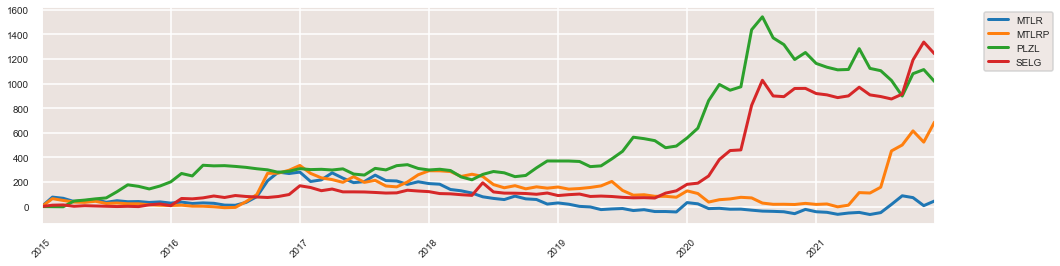

In [211]:
plot_data(df_percent_diff_last2base[['MTLR', 'MTLRP', 'PLZL', 'SELG']], fig_size=(16,4))

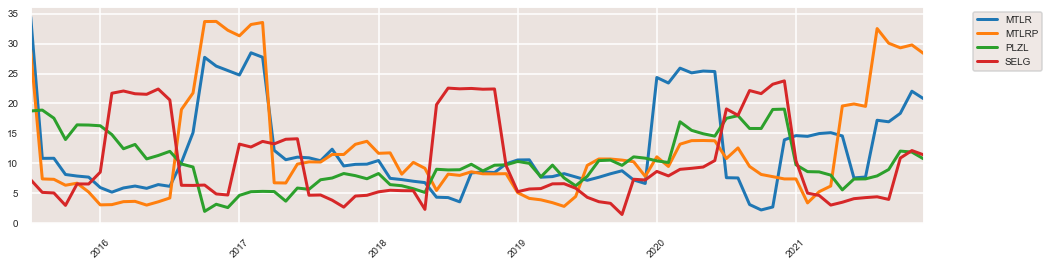

In [212]:
plot_data(df_percent_diff_Y2Y[['MTLR', 'MTLRP', 'PLZL', 'SELG']], fig_size=(16,4))

**Выводы**
- Методами детекции аномалий нам удалось выделить те наблюдения, рост которых харакетризовалсь резким ростом волатильности, а не длительным трендом

## 4.4 Кластеризация по признаковому пространству

### 4.4.1 K_means

Проведем класстерный анализ методом K_means

Сначала воспользуемся "Методом логтя" и "Методом силуэта" анализа количества возможных кластеров в данных

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.39it/s]


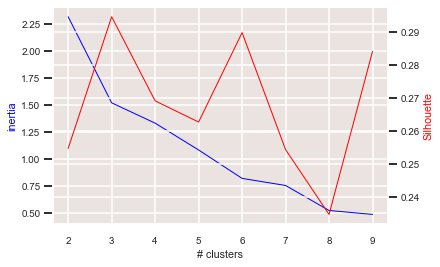

In [214]:
plot_Kmeans_explore(df_features_norm_scaled_PCA)

Посмотрим на устойчивость оценок при повторных инициализациях:

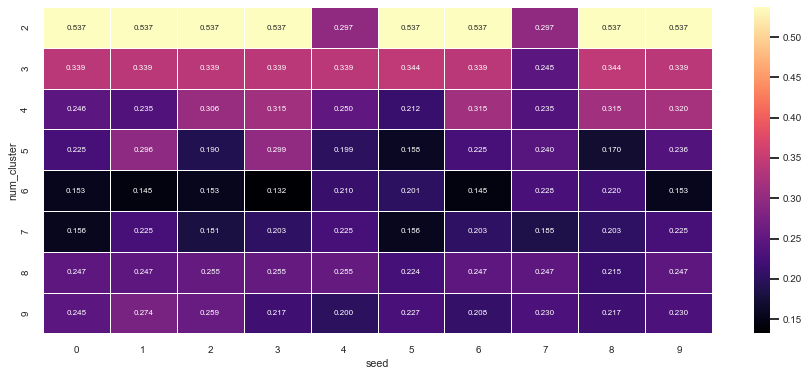

In [215]:
num_df_scaled = df_features_norm_scaled_PCA
results = []

for i in range(2,10):
    for r in range(10):
        kmeans = KMeans(n_clusters=i, random_state=r)
        c_labels = kmeans.fit_predict(num_df_scaled)
        sil_ave = silhouette_score(num_df_scaled, c_labels)
        results.append([i, r, sil_ave])
        
res_df = pd.DataFrame(results, columns=['num_cluster', 'seed', 'sil_score'])
pivot_kmeans = pd.pivot_table(res_df, index='num_cluster', columns='seed', values='sil_score')

plt.figure(figsize=(15,6))
plt.tight_layout
sns.heatmap(pivot_kmeans, annot=True, linewidths=0.5, fmt='.3f', cmap='magma', annot_kws={"size":8});

По результатам оценок не можем выделить потенциально 2 или 3 кластера

In [243]:
km = KMeans(n_clusters=2, random_state=0)
clusters = pd.Series(km.fit_predict(df_features_norm_scaled_PCA)+1)
display(pd.DataFrame(clusters).value_counts(normalize=True))

1    0.916667
2    0.083333
dtype: float64

In [248]:
df_features.iloc[list(clusters[clusters==2].index)]


,"Полная относительно IMOEX доходность, %",%г/г__mean,%г/г__variance,%г/г__maximum
MTLR,45.041389,12.009328,49.814406,28.462326
MTLRP,687.228315,12.214816,79.840815,33.703163
SELG,1242.341175,10.228848,48.395801,23.770846


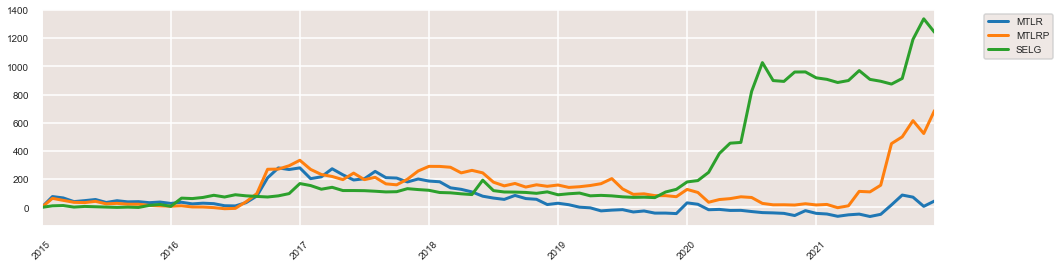

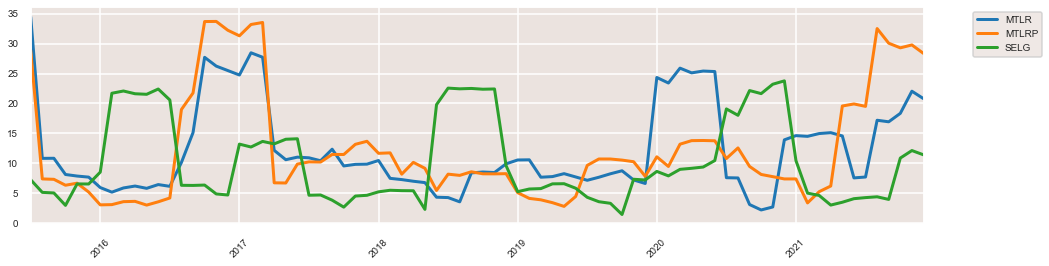

In [249]:
columns = list(df_features.iloc[list(clusters[clusters==2].index)].index)

plot_data(df_percent_diff_last2base[columns], fig_size=(16,4))

plot_data(df_percent_diff_Y2Y[columns], fig_size=(16,4))

### 4.4.2 Иерархическая кластеризация

Попробуем другой метод кластеризации - Иерархическая кластеризация.

Сначала проанализируем количество возможных кластеров в данных.

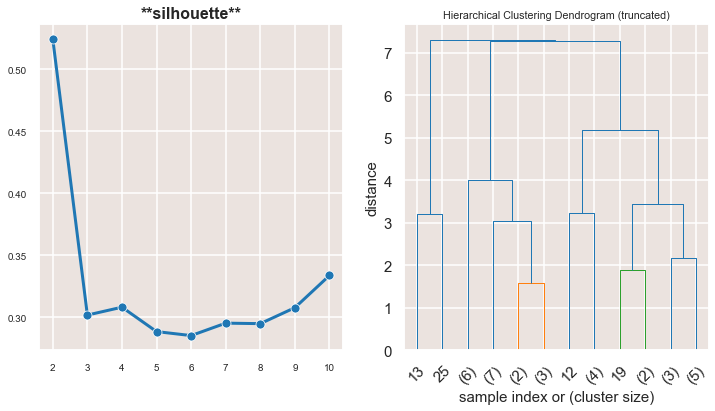

In [252]:
hierarchy_clustering_explorer (df_features_norm_scaled_PCA, metric='euclidean', MAX_CLUSTERS=10)

По результатам оценок можем сказать, что потенциально в данных можем выделить 2 кластера

In [255]:
clusters_df = get_hierarchy_clusters(df_features_norm_scaled_PCA, metric='euclidean',clusters_count=3)

Распределение кластеров:


,clusters %
0,50.000000
1,44.444444
2,5.555556


#### ___Сравнение кластеров

Посмотрим на малый кластер

In [259]:
df_features.iloc[list(clusters_df[clusters_df['cluster']==2].index)]

,"Полная относительно IMOEX доходность, %",%г/г__mean,%г/г__variance,%г/г__maximum
ALRS,-73.985713,5.643867,4.427819,10.951065
BSPB,82.407834,6.552822,7.400270,12.904485
GAZP,8.215716,4.548183,6.857010,12.275322
GMKN,-32.608947,5.726353,1.664739,8.852305
MTSS,-92.648204,3.851820,1.261599,6.129220
MOEX,-10.966989,5.846738,2.065347,9.587690
LKOH,5.747139,4.223426,2.591735,7.149098
RTKM,-129.829611,5.090222,3.353945,9.273711
RTKMP,-93.846273,4.469684,3.146953,7.660218
SBER,247.366809,4.851317,4.700116,9.519146


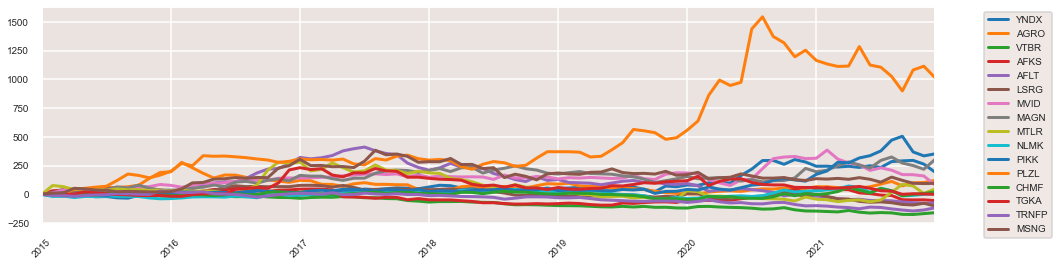

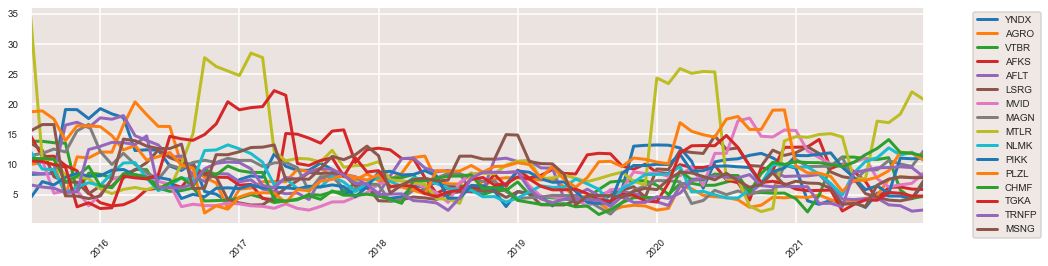

In [263]:
columns = list(df_features.iloc[list(clusters_df[clusters_df['cluster']==3].index)].index)

plot_data(df_percent_diff_last2base[columns], fig_size=(16,4))

plot_data(df_percent_diff_Y2Y[columns], fig_size=(16,4))

**Выводы**
- По графикам видно, что наблюдения, попавшие в малый кластер имеют болеее сильную волатильность. Сравнив описательные статистики можно заметить, что кластеры сильно отличаются средними значениями по признакам **'Полная относительно IMOEX доходность, %'** и **'%__standard_deviation'**, что подтверждает наши выводы по графикам

### 4.4.3 DBSCAN

Посмотрим удалось ли выделить кластеры плотностным методом DBSCAN

In [266]:
DBSCAN_results.sort_values(by='silhouette', ascending=False).head(15)

,silhouette,clusters,noise
"eps=1.4, samples=7",0.505077,1.0,11.0
"eps=1.3, samples=2",0.505077,1.0,11.0
"eps=1.1, samples=2",0.505077,1.0,11.0
"eps=1.1, samples=3",0.505077,1.0,11.0
"eps=1.1, samples=4",0.505077,1.0,11.0
"eps=1.1, samples=5",0.505077,1.0,11.0
"eps=1.2, samples=2",0.505077,1.0,11.0
"eps=1.2, samples=3",0.505077,1.0,11.0
"eps=1.2, samples=4",0.505077,1.0,11.0
"eps=1.2, samples=5",0.505077,1.0,11.0


Методом DBSCAN не удалось выделить кластеры наблюдений.

# 5. Визуальный анализ

## 5.1 Формирование финансовых признаков

In [271]:
tickers_list = list(df_features.index)
df_FinanceData_features = pd.DataFrame()
for ticker in tqdm_notebook(tickers_list, desc='tickers', leave=False):
    try:
        data = pd.read_pickle(f'data/parsing/MSFO_{ticker}.pkl')
        df_percent = data.copy()
        
        # Отбор промежутка
        df_percent.index = [int(i) for i in df_percent.index]
        df_percent = df_percent.loc[2015:2021]
        
        # Выборка
        df_percent = df_percent[['Див доход, ао, %', 'Дивиденды/прибыль, %', 'Чистая рентаб, %']]
        
        # Очистка
        df_percent = df_percent.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
        df_percent = df_percent.dropna()
        if df_percent.shape[0] == 0:
            print(f'AHTUNG! Недостаточно данных: пропуск {ticker}')
            continue

        # Формирование сводных признаков
        ticker_features = pd.DataFrame(index = [ticker])
        
     
        ticker_features['Чистая рентаб, %_mean'] = df_percent['Чистая рентаб, %'].dropna().mean()
        ticker_features['Див доход, ао, %_mean'] = df_percent['Див доход, ао, %'].dropna().mean()

        ticker_features['Дивиденды/прибыль, %_mean'] = df_percent['Дивиденды/прибыль, %'].dropna().mean()
        
        df_FinanceData_features = pd.concat([df_FinanceData_features, ticker_features], axis=0)
    
    except:
        print(f'AHTUNG! Непредвиденная ошибка по {ticker}: ')
        continue

tickers:   0%|          | 0/36 [00:00<?, ?it/s]

AHTUNG! Непредвиденная ошибка по MTLRP: 
AHTUNG! Непредвиденная ошибка по RTKMP: 
AHTUNG! Непредвиденная ошибка по SBERP: 
AHTUNG! Непредвиденная ошибка по TATNP: 


In [272]:
for col in ['MTLRP', 'RTKMP', 'SBERP', 'TATNP']:
    df_FinanceData_features.loc[col] = df_FinanceData_features.loc[col[:-1]]

Посмотрим на сформированные финансовые признаки

In [273]:
df_FinanceData_features.head()

,"Чистая рентаб, %_mean","Див доход, ао, %_mean","Дивиденды/прибыль, %_mean"
YNDX,13.328571,0.000000,0.000000
AGRO,16.057143,5.928571,47.000000
ALRS,26.300000,7.814286,84.714286
VTBR,20.644286,2.714286,157.857143
BSPB,24.471429,4.271429,13.714286


## 5.2 Построение расстояний по dtw метрике от IMOEX

<AxesSubplot:title={'center':'После стандартизации'}>

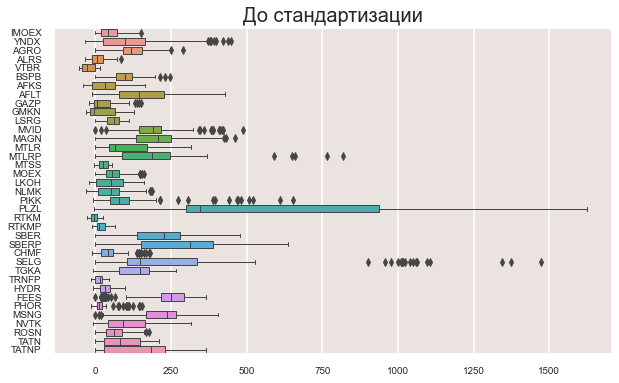

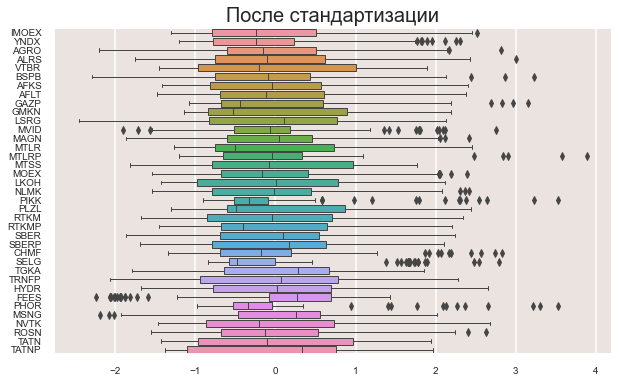

In [274]:
plt.figure(figsize=(10,6))
plt.title('До стандартизации', fontsize=20)
sns.boxplot(data=df_percent_last2base, orient='h')

df_percent_last2base_scaled = pd.DataFrame(scaler.fit_transform(df_percent_last2base), 
                                      columns=scaler.get_feature_names_out(),
                                      index=df_percent_last2base.index)

plt.figure(figsize=(10,6))
plt.title('После стандартизации', fontsize=20)
sns.boxplot(data=df_percent_last2base_scaled, orient='h')

Теперь построим взаимные расстояния

In [275]:
dtw_score = cdist_dtw(df_percent_last2base_scaled.drop(columns=['IMOEX']).T, df_percent_last2base_scaled[['IMOEX']].T)
dtw_score = pd.DataFrame(dtw_score, index = list(df_percent_last2base_scaled.drop(columns=['IMOEX']).columns), columns=['dtw'] )
dtw_score.head()

,dtw
YNDX,1.646491
AGRO,5.034173
ALRS,4.096717
VTBR,13.454855
BSPB,4.057075


Сформируем общий датафрейм и сформируем признаки

In [294]:
common_df = pd.concat([dtw_score, df_FinanceData_features], axis=1)
common_df['Относительная доходность'] = df_features['Полная относительно IMOEX доходность, %'].apply(lambda x: 'Положительная' if x>=0 else 'Отрицательная')
common_df['Относительная доходность г/г, %'] = df_features['%г/г__mean'].apply(lambda x: 'Положительная' if x>=0 else 'Отрицательная')
common_df['Средняя доходность г/г, %'] = df_features['%г/г__mean']
common_df['Полная относительная доходность, %'] = df_features['Полная относительно IMOEX доходность, %'].apply(lambda x: abs(x))
common_df['Дисперсия колебаний г/г, %'] = df_features['%г/г__variance']
common_df['Чистая рентаб, %_mean'] = df_FinanceData_features['Чистая рентаб, %_mean'].apply(lambda x: x if x>0 else 0)

In [309]:
import plotly.express as px

plot_1 = px.scatter(common_df, x='Дисперсия колебаний г/г, %', y='Чистая рентаб, %_mean',
                 hover_name=common_df.index,log_x=True, color="Относительная доходность", size='Полная относительная доходность, %')

In [311]:
plot_1.show()

Еще раз посмотри на наши выбросы

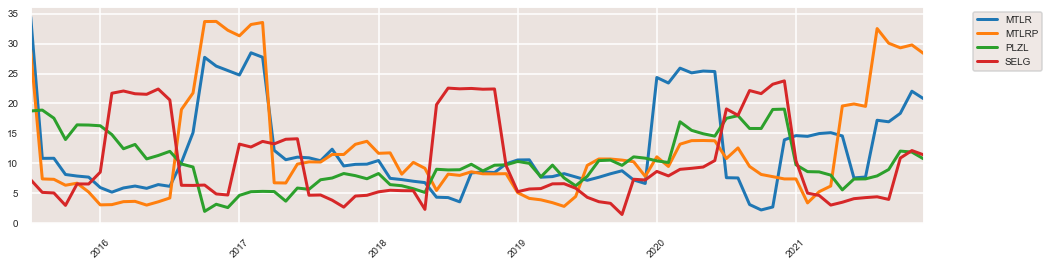

In [282]:
plot_data(df_percent_diff_Y2Y[['MTLR', 'MTLRP', 'PLZL', 'SELG']], fig_size=(16,4))

По построенному 'Bubble plot' отчетливо можно заметить аномальные объекты, которые совпадают с нами ранее обнаруженными аномалиями.

Однако, стоит обратить внимание на 'PLZ' - он значительно отличается от прочих выбросов и на 'Bubble plot' находится ближе к 'SBER' и 'SBERP', что позволяет рассматривать его не как выброс.

Сравним динамику колебаний доходности г/г 'PLZL', 'SBER', 'SBERP' :

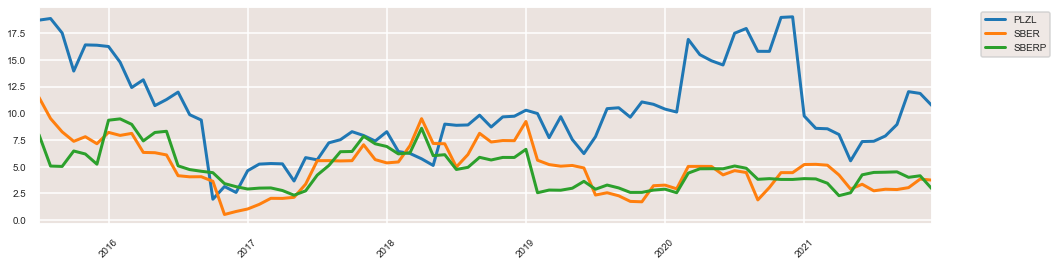

In [293]:
plot_data(df_percent_diff_Y2Y[[ 'PLZL', 'SBER', 'SBERP']], fig_size=(16,4))

'PLZL' действительно характерны более сильные по амплитуде колебания, чем у 'SBER', 'SBERP', но он значительно ближе, чем к 'MTLR', 'MTLRP', 'SELG'

Посмотрим на 'Bubble' график "Разброса" наблюдений по метрике dtw и средней дисперсии колебаний с отображение доходности:

In [325]:
import plotly.express as px

plot_2 = px.scatter(common_df, x='dtw', y='Дисперсия колебаний г/г, %',
                 hover_name=common_df.index,log_x=True, color="Относительная доходность", size='Полная относительная доходность, %')

In [306]:
plot_2.show()

На данном графике еще более отчетливо видно , что 'PLZL' значительно ближе к  'SBER', 'SBERP'. Что можно рассматривать как дополнительный аргумент рассматривать 'PLZ' не как выброс

# 6. Заключение

По результатам проведенного кластерного анализа можно сделать вывод, что от рынка за рассматриваемый период стоит выделить следующую часть, для дальнейшего анализа и отбора:
- **'YNDX'**, **'MAGN'**, **'PIKK'**, **'SBER'**, **'SBERP'**, **'NVTK'**, **PLZ**. Данные наблюдения показали высокую доходность за период и тренд к росту доходности относительно доходности индекса с малой волатильностью доходности г/г.

При этом стоит настороженно отнестись к результатам следующих наблюдений, показавших высокую доходность за период, но попавших под классификацию - выбросы:
- **'MTLRP'**, **'MTLR'**, **'SELG'**.